In [ ]:
!pip install transformers --quiet

In [1]:
from pkg.word2vec_vocab import docs_to_vocab_ids,embedding_matrix
from pkg.show_comparison import make_plot

import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds

from sklearn.model_selection import train_test_split

import sklearn as sk
import os
import nltk
from nltk.data import find



import re

import pandas as pd
pd.set_option('max_columns', None)

from pkg.data_frame import eda_nltk, remove_tags

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes = True)


import warnings
warnings.filterwarnings("ignore")



[nltk_data] Downloading package word2vec_sample to
[nltk_data]     /Users/peeti_mac/nltk_data...
[nltk_data]   Package word2vec_sample is already up-to-date!
2023-09-23 18:51:16.956677: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
dataframe = input(': ') #data/reviews_Automotive_5.json.gz
df = eda_nltk(dataframe)
df.head()

:  data/reviews_Automotive_5.json.gz


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A3F73SC1LY51OO,B00002243X,Alan Montgomery,"[4, 4]",I needed a set of jumper cables for my new car...,5,Work Well - Should Have Bought Longer Ones,1313539200,"08 17, 2011"
1,A20S66SKYXULG2,B00002243X,alphonse,"[1, 1]","These long cables work fine for my truck, but ...",4,Okay long cables,1315094400,"09 4, 2011"
2,A2I8LFSN2IS5EO,B00002243X,Chris,"[0, 0]",Can't comment much on these since they have no...,5,Looks and feels heavy Duty,1374710400,"07 25, 2013"
3,A3GT2EWQSO45ZG,B00002243X,DeusEx,"[19, 19]",I absolutley love Amazon!!! For the price of ...,5,Excellent choice for Jumper Cables!!!,1292889600,"12 21, 2010"
4,A3ESWJPAVRPWB4,B00002243X,E. Hernandez,"[0, 0]",I purchased the 12' feet long cable set and th...,5,"Excellent, High Quality Starter Cables",1341360000,"07 4, 2012"


# EDA
## add a new column for sentiment


(20473, 10)


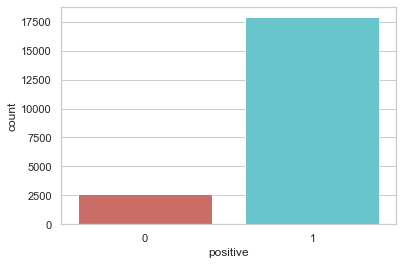

In [3]:
df['positive'] = df.overall.apply(lambda x: 1 if x >= 4 else 0)
print(df.shape)

review_df = df[['reviewText','positive']]
review_df['reviewText']=review_df['reviewText'].apply(lambda cw : remove_tags(cw))


sns.countplot(x='positive',data = review_df, palette = 'hls')
plt.show()

## handling the imbalanced data

In [4]:
max_cnt = review_df.query('positive == 0').shape[0]
print(f'We should select only {max_cnt} count for both positive/ negative review')
sample_df = review_df.groupby(['positive']).apply(lambda x: x.sample(max_cnt))
sample_df.shape[0]

We should select only 2578 count for both positive/ negative review


5156

In [5]:
s = 0.0
for i in sample_df['reviewText']:
    word_list = i.split()
    s = s + len(word_list)
print("Average length of each review : ",s/sample_df.shape[0])
pos = 0
for i in range(sample_df.shape[0]):
    if sample_df.iloc[i]['positive'] == 1:
        pos = pos + 1
neg = sample_df.shape[0]-pos
print("Percentage of reviews with positive sentiment is "+str(pos/sample_df.shape[0]*100)+"%")
print("Percentage of reviews with negative sentiment is "+str(neg/sample_df.shape[0]*100)+"%")

Average length of each review :  97.588828549263
Percentage of reviews with positive sentiment is 50.0%
Percentage of reviews with negative sentiment is 50.0%


In [6]:
sample_df = sample_df[['reviewText','positive']].reset_index(level=0, drop=True)


# let's tokenize the data

For the Transformer library we need to import the tokenizer and the TensorFlow model:

In [7]:
from transformers import BertTokenizer, TFBertModel

from transformers import logging
logging.set_verbosity_error()

In [ ]:
sample_df[:2]['reviewText'].values

In [ ]:
# tokenizer = AutoTokenizer.from_pretrained('roberta-large')
# tr_tok = tokenizer(list(x_train), return_tensors='tf', truncation=True, padding=True, max_length=128)


In [8]:
X = list(sample_df['reviewText'].values)
y = list(sample_df['positive'].values)

X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size = 0.2)

In [9]:
X_train[:3]

['it was not clear from the product description but these are fully enclosed blades designed to keep ice from causing them to lose contact i live in a part of arizona where i don t need that also these are about the ugliest blades i ve ever seen big and blocky i m sure they work great in snow and ice but i don t need that also they don t flex out at the tip as much as regular blades the the outer 3 34 did not even touch on the passenger side of my 2001 tundra windshield with the blade at rest ',
 'pulled my jeep out of a puddle with a moderate tug and it has begun to fray after one use looks like it will be around for a little longer but i didn t expect that to happen ',
 'first one i ordered came right out of the box with the fan torn off and rattling around in the sealed cage i could see it was broken before i even opened the package bought it from amazon so was able to exchange it for another one very fast delivery returns made simple for sure the next one was just as the other revi

# BERT Basics¶

We now need to settle on the pre-trained BERT model we want to use. We will leverage 'bert-base-cased'.

We need to create the corresponding model and tokenizer:

In [10]:
checkpoint = 'bert-base-cased'
bert_tokenizer = BertTokenizer.from_pretrained(checkpoint)
bert_model = TFBertModel.from_pretrained(checkpoint)


In [11]:
bert_tokenizer.tokenize('This is great!')

['This', 'is', 'great', '!']

In [12]:
bert_tokenizer.tokenize('Pneumonia can be very serious.')

['P', '##ne', '##um', '##onia', 'can', 'be', 'very', 'serious', '.']

In [13]:
bert_tokenizer.tokenize('This tree is 1253 years old.')

['This', 'tree', 'is', '125', '##3', 'years', 'old', '.']

Ouch! Many more complex terms are not in BERT's vocabulary and are split up.

**Question:** in what type of NLP problems can this lead to complications?

Next, how do we generate the BERT input with its tokenizer? Fortunately, by now Huggingface's tokenizer implementation makes this rather straightforward:

In [21]:
bert_tokenizer(['This is great!'])

{'input_ids': [[101, 1188, 1110, 1632, 106, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1]]}

In [22]:
bert_input = bert_tokenizer(['This great!', 'This is terrible!'],
              max_length=10,
              truncation=True,
              padding='max_length',
              return_tensors='tf')

bert_input

{'input_ids': <tf.Tensor: shape=(2, 10), dtype=int32, numpy=
array([[ 101, 1188, 1632,  106,  102,    0,    0,    0,    0,    0],
       [ 101, 1188, 1110, 6434,  106,  102,    0,    0,    0,    0]],
      dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(2, 10), dtype=int32, numpy=
array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(2, 10), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 0, 0, 0, 0]], dtype=int32)>}



[Return to Top](#returnToTop)  
<a id = 'BERTClassification'></a>

# Text Classification with BERT (using the Pooler Output)

The BERT model returns two values that can be exploited for classification purposes. One is the last_hidden_state which is the sequence of hidden-states at the output of the last layer of the model.  The second one is the pooler output, with is the output of the [CLS] token where another linear layer is added on top followed by a tanh. This pooler output can be used for classification purposes.

Let us create the data. More will be discussed in class. (We can limit the training and test data sizes for expedience in class.)

In [14]:
# BERT Tokenization of training and test data

num_train_examples = 20000      # set number of train examples - 1500 for realtime demo
num_test_examples = 5000        # set number of test examples - 500 for realtime demo

MAX_SEQUENCE_LENGTH = 128                 # set max_length of the input sequence

# all_train_examples = [x.decode('utf-8') for x in X_train.numpy()]
# all_test_examples = [x.decode('utf-8') for x in X_test.numpy()]



all_train_examples = X_train
all_test_examples = X_test


x_train = bert_tokenizer(all_train_examples[:num_train_examples],
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
y_train = Y_train[:num_train_examples]

x_test = bert_tokenizer(all_test_examples[:num_test_examples],
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
y_test = Y_test[:num_test_examples]

### define the model

In [15]:
def create_bert_classification_model(bert_model,
                                     num_train_layers=0,
                                     hidden_size = 200,
                                     dropout=0.3,
                                     learning_rate=0.00005):
    """
    Build a simple classification model with BERT. Use the Pooler Output for classification purposes
    """
    if num_train_layers == 0:
        # Freeze all layers of pre-trained BERT model
        bert_model.trainable = False

    elif num_train_layers == 12:
        # Train all layers of the BERT model
        bert_model.trainable = True

    else:
        # Restrict training to the num_train_layers outer transformer layers
        retrain_layers = []

        for retrain_layer_number in range(num_train_layers):

            layer_code = '_' + str(11 - retrain_layer_number)
            retrain_layers.append(layer_code)


        print('retrain layers: ', retrain_layers)

        for w in bert_model.weights:
            if not any([x in w.name for x in retrain_layers]):
                #print('freezing: ', w)
                w._trainable = False

    input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    bert_out = bert_model(bert_inputs)

    pooler_token = bert_out[1]
    #cls_token = bert_out[0][:, 0, :]

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(pooler_token)


    hidden = tf.keras.layers.Dropout(dropout)(hidden)


    classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_layer')(hidden)

    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])

    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                                 metrics='accuracy')

    return classification_model

We'll call our model now, via the function we just defined, but we'll freeze all of the layers to make the fine tuning go much faster

In [16]:
#let's get a fresh instance of the bert_model -- good practice
bert_model = TFBertModel.from_pretrained(checkpoint)
bert_classification_model = create_bert_classification_model(bert_model, num_train_layers=0)

In [17]:
#confirm all layers are frozen
bert_classification_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(None, 128)]                0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(None, 128)]                0         []                            
 r)                                                                                               
                                                                                                  
 token_type_ids_layer (Inpu  [(None, 128)]                0         []                            
 tLayer)                                                                                      

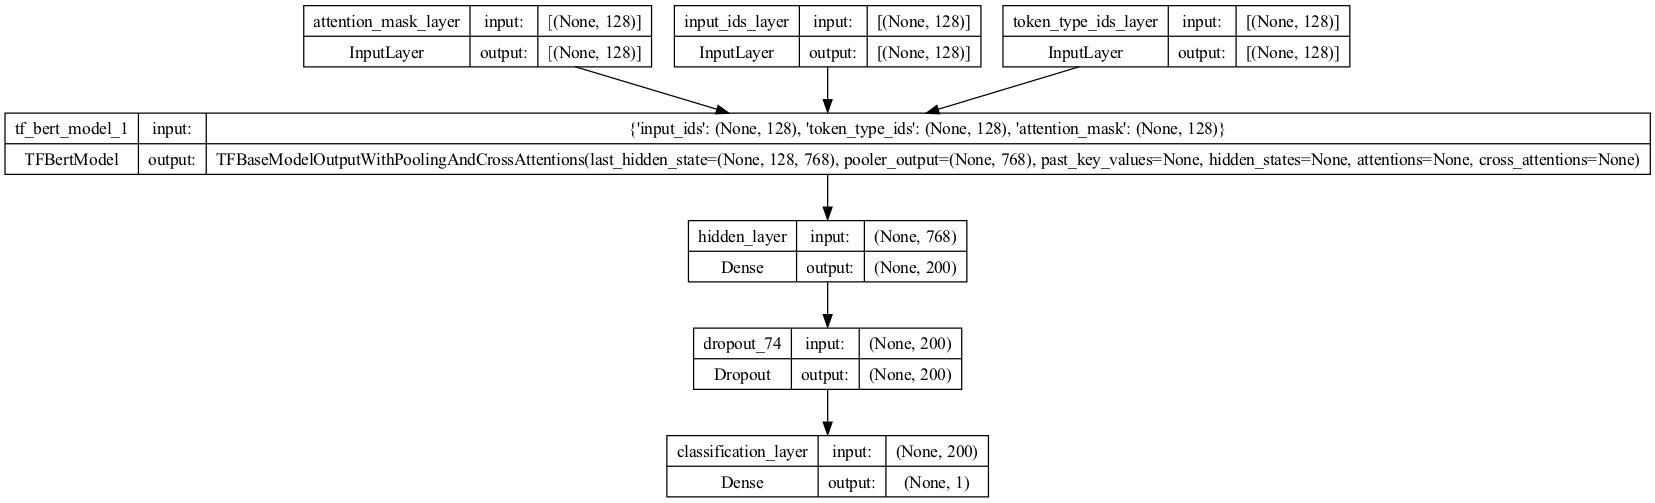

In [18]:
keras.utils.plot_model(bert_classification_model, show_shapes=True, dpi=90)

In [19]:
x_test.attention_mask

<tf.Tensor: shape=(1032, 128), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 0],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>

In [24]:
def my_func(arg):
  arg = tf.convert_to_tensor(arg, dtype=tf.float32)
  return arg

In [26]:
y_train = my_func(y_train)
y_test = my_func(y_test)

In [27]:
bert_classification_model_history = bert_classification_model.fit(
    [x_train.input_ids, x_train.token_type_ids, x_train.attention_mask],
    y_train,
    validation_data=([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask], y_test),
    batch_size=32,
    epochs=2
)

Epoch 1/2
129/129 [==============================] - 780s 6s/step - loss: 0.7171 - accuracy: 0.5182 - val_loss: 0.6799 - val_accuracy: 0.5727
Epoch 2/2
129/129 [==============================] - 749s 6s/step - loss: 0.6991 - accuracy: 0.5364 - val_loss: 0.6803 - val_accuracy: 0.5727


using a transformed version of the CLS token (called the pooler output) from the BERT model, which was pre-trained using the next sentence prediction task. It might not capture the useful context from the sentence that we need for our task. So we might need to unfreeze some of the pre-trained BERT layers and update their weights (fine-tune them) for our task.
                                                                                                                                                                                                                                                                                                                                                           
**What if we just set num_train_layers=4, to unfreeze only the top four layers of the BERT model?**                                                                                                                                                                                                                                                                                                                                                           

In [28]:
bert_model = TFBertModel.from_pretrained(checkpoint)
bert_classification_model = create_bert_classification_model(bert_model, num_train_layers=4)

bert_classification_model_history = bert_classification_model.fit(
    [x_train.input_ids, x_train.token_type_ids, x_train.attention_mask],
    y_train,
    validation_data=([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask], y_test),
    batch_size=32,
    epochs=2
)

retrain layers:  ['_11', '_10', '_9', '_8']
Epoch 1/2
129/129 [==============================] - 1061s 8s/step - loss: 0.5356 - accuracy: 0.7333 - val_loss: 0.4421 - val_accuracy: 0.7994
Epoch 2/2
129/129 [==============================] - 935s 7s/step - loss: 0.3884 - accuracy: 0.8317 - val_loss: 0.4155 - val_accuracy: 0.8052


**set num_train_layers=12**

In [29]:
bert_model = TFBertModel.from_pretrained(checkpoint)
bert_classification_model = create_bert_classification_model(bert_model, num_train_layers=12)

bert_classification_model_history = bert_classification_model.fit(
    [x_train.input_ids, x_train.token_type_ids, x_train.attention_mask],
    y_train,
    validation_data=([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask], y_test),
    batch_size=32,
    epochs=2
)

Epoch 1/2
129/129 [==============================] - 1677s 13s/step - loss: 0.5913 - accuracy: 0.6758 - val_loss: 0.4411 - val_accuracy: 0.7926
Epoch 2/2
129/129 [==============================] - 1542s 12s/step - loss: 0.3354 - accuracy: 0.8581 - val_loss: 0.4627 - val_accuracy: 0.7674


# Maximum number of layer performs the best